In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from feature_engine import imputation
from feature_engine import encoding

# pipeline utility
from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures

# hyper-parameter tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

# metrics to evaluate models
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor

# neighbors models
from sklearn.neighbors import KNeighborsRegressor

# tree models
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor

In [2]:
house_data = pd.read_csv('../data/train.csv', index_col='Id')
X = house_data.drop(labels='SalePrice', axis=1)
Y = house_data['SalePrice']
X.shape, Y.shape

((1460, 79), (1460,))

In [14]:
cv = RepeatedKFold(n_splits=6, n_repeats=12, random_state=64)

In [17]:
base_pipeline = Pipeline(steps=[('most_miss_cat', imputation.CategoricalImputer(variables=['Alley',
                                                                                           'FireplaceQu',
                                                                                           'PoolQC',
                                                                                           'Fence',
                                                                                           'MiscFeature'])),
                                ('least_miss_cat', imputation.RandomSampleImputer(random_state='LotArea',
                                                                                  seed='observation',
                                                                                  variables=['GarageCond',
                                                                                             'GarageType',
                                                                                             'GarageFinish',
                                                                                             'GarageQual',
                                                                                             'BsmtExposure',
                                                                                             'BsmtFinType2',
                                                                                             'BsmtCond',
                                                                                             'BsmtQual',
                                                                                             'BsmtFinType1',
                                                                                             'MasVnrType',
                                                                                             'Electrical'])),
                                ('least_miss_num', imputation.RandomSampleImputer(random_state='LotArea',
                                                                                  seed='observation',
                                                                                  variables=['LotFrontage',
                                                                                             'GarageYrBlt',
                                                                                             'MasVnrArea'])),
                                ('encode', encoding.OrdinalEncoder(
                                    variables=X.select_dtypes(include=object).columns.to_list())),
                                ('scaling', RobustScaler()),
                                ('transform', QuantileTransformer(output_distribution='normal')),
                                ('scale_to_range', MinMaxScaler()),
                                ('feature_selection', SelectKBest(score_func=mutual_info_regression,
                                                                  k=20))]
                         )

base_pipeline.get_params()

{'memory': None,
 'steps': [('most_miss_cat',
   CategoricalImputer(variables=['Alley', 'FireplaceQu', 'PoolQC', 'Fence',
                                 'MiscFeature'])),
  ('least_miss_cat',
   RandomSampleImputer(random_state='LotArea', seed='observation',
                       variables=['GarageCond', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'BsmtExposure', 'BsmtFinType2',
                                  'BsmtCond', 'BsmtQual', 'BsmtFinType1',
                                  'MasVnrType', 'Electrical'])),
  ('least_miss_num',
   RandomSampleImputer(random_state='LotArea', seed='observation',
                       variables=['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])),
  ('encode',
   OrdinalEncoder(variables=['MSZoning', 'Street', 'Alley', 'LotShape',
                             'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
                             'Neighborhood', 'Condition1', 'Condition2',
                             'Bl

In [23]:
X_ = base_pipeline.fit_transform(X, Y)
train_x, test_x, train_y, test_y = train_test_split(X_, Y, test_size=0.2, random_state=48)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((1168, 20), (292, 20), (1168,), (292,))

In [24]:
ols_estimator = Pipeline(steps=[('poly_func', PolynomialFeatures()),
                                ('model', LinearRegression())])
ols_estimator.get_params()

{'memory': None,
 'steps': [('poly_func', PolynomialFeatures()), ('model', LinearRegression())],
 'verbose': False,
 'poly_func': PolynomialFeatures(),
 'model': LinearRegression(),
 'poly_func__degree': 2,
 'poly_func__include_bias': True,
 'poly_func__interaction_only': False,
 'poly_func__order': 'C',
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__n_jobs': None,
 'model__normalize': 'deprecated',
 'model__positive': False}

In [25]:
gs_ols = GridSearchCV(estimator=ols_estimator,
                      param_grid={'poly_func__degree': [2, 3, 4]},
                      scoring={'r2': make_scorer(r2_score),
                               'me': make_scorer(max_error)
                               },
                      refit='r2',
                      cv=cv,
                      n_jobs=-1
                      )
gs_ols.fit(train_x, train_y)

GridSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
             estimator=Pipeline(steps=[('poly_func', PolynomialFeatures()),
                                       ('model', LinearRegression())]),
             n_jobs=-1, param_grid={'poly_func__degree': [2, 3, 4]}, refit='r2',
             scoring={'me': make_scorer(max_error),
                      'r2': make_scorer(r2_score)})

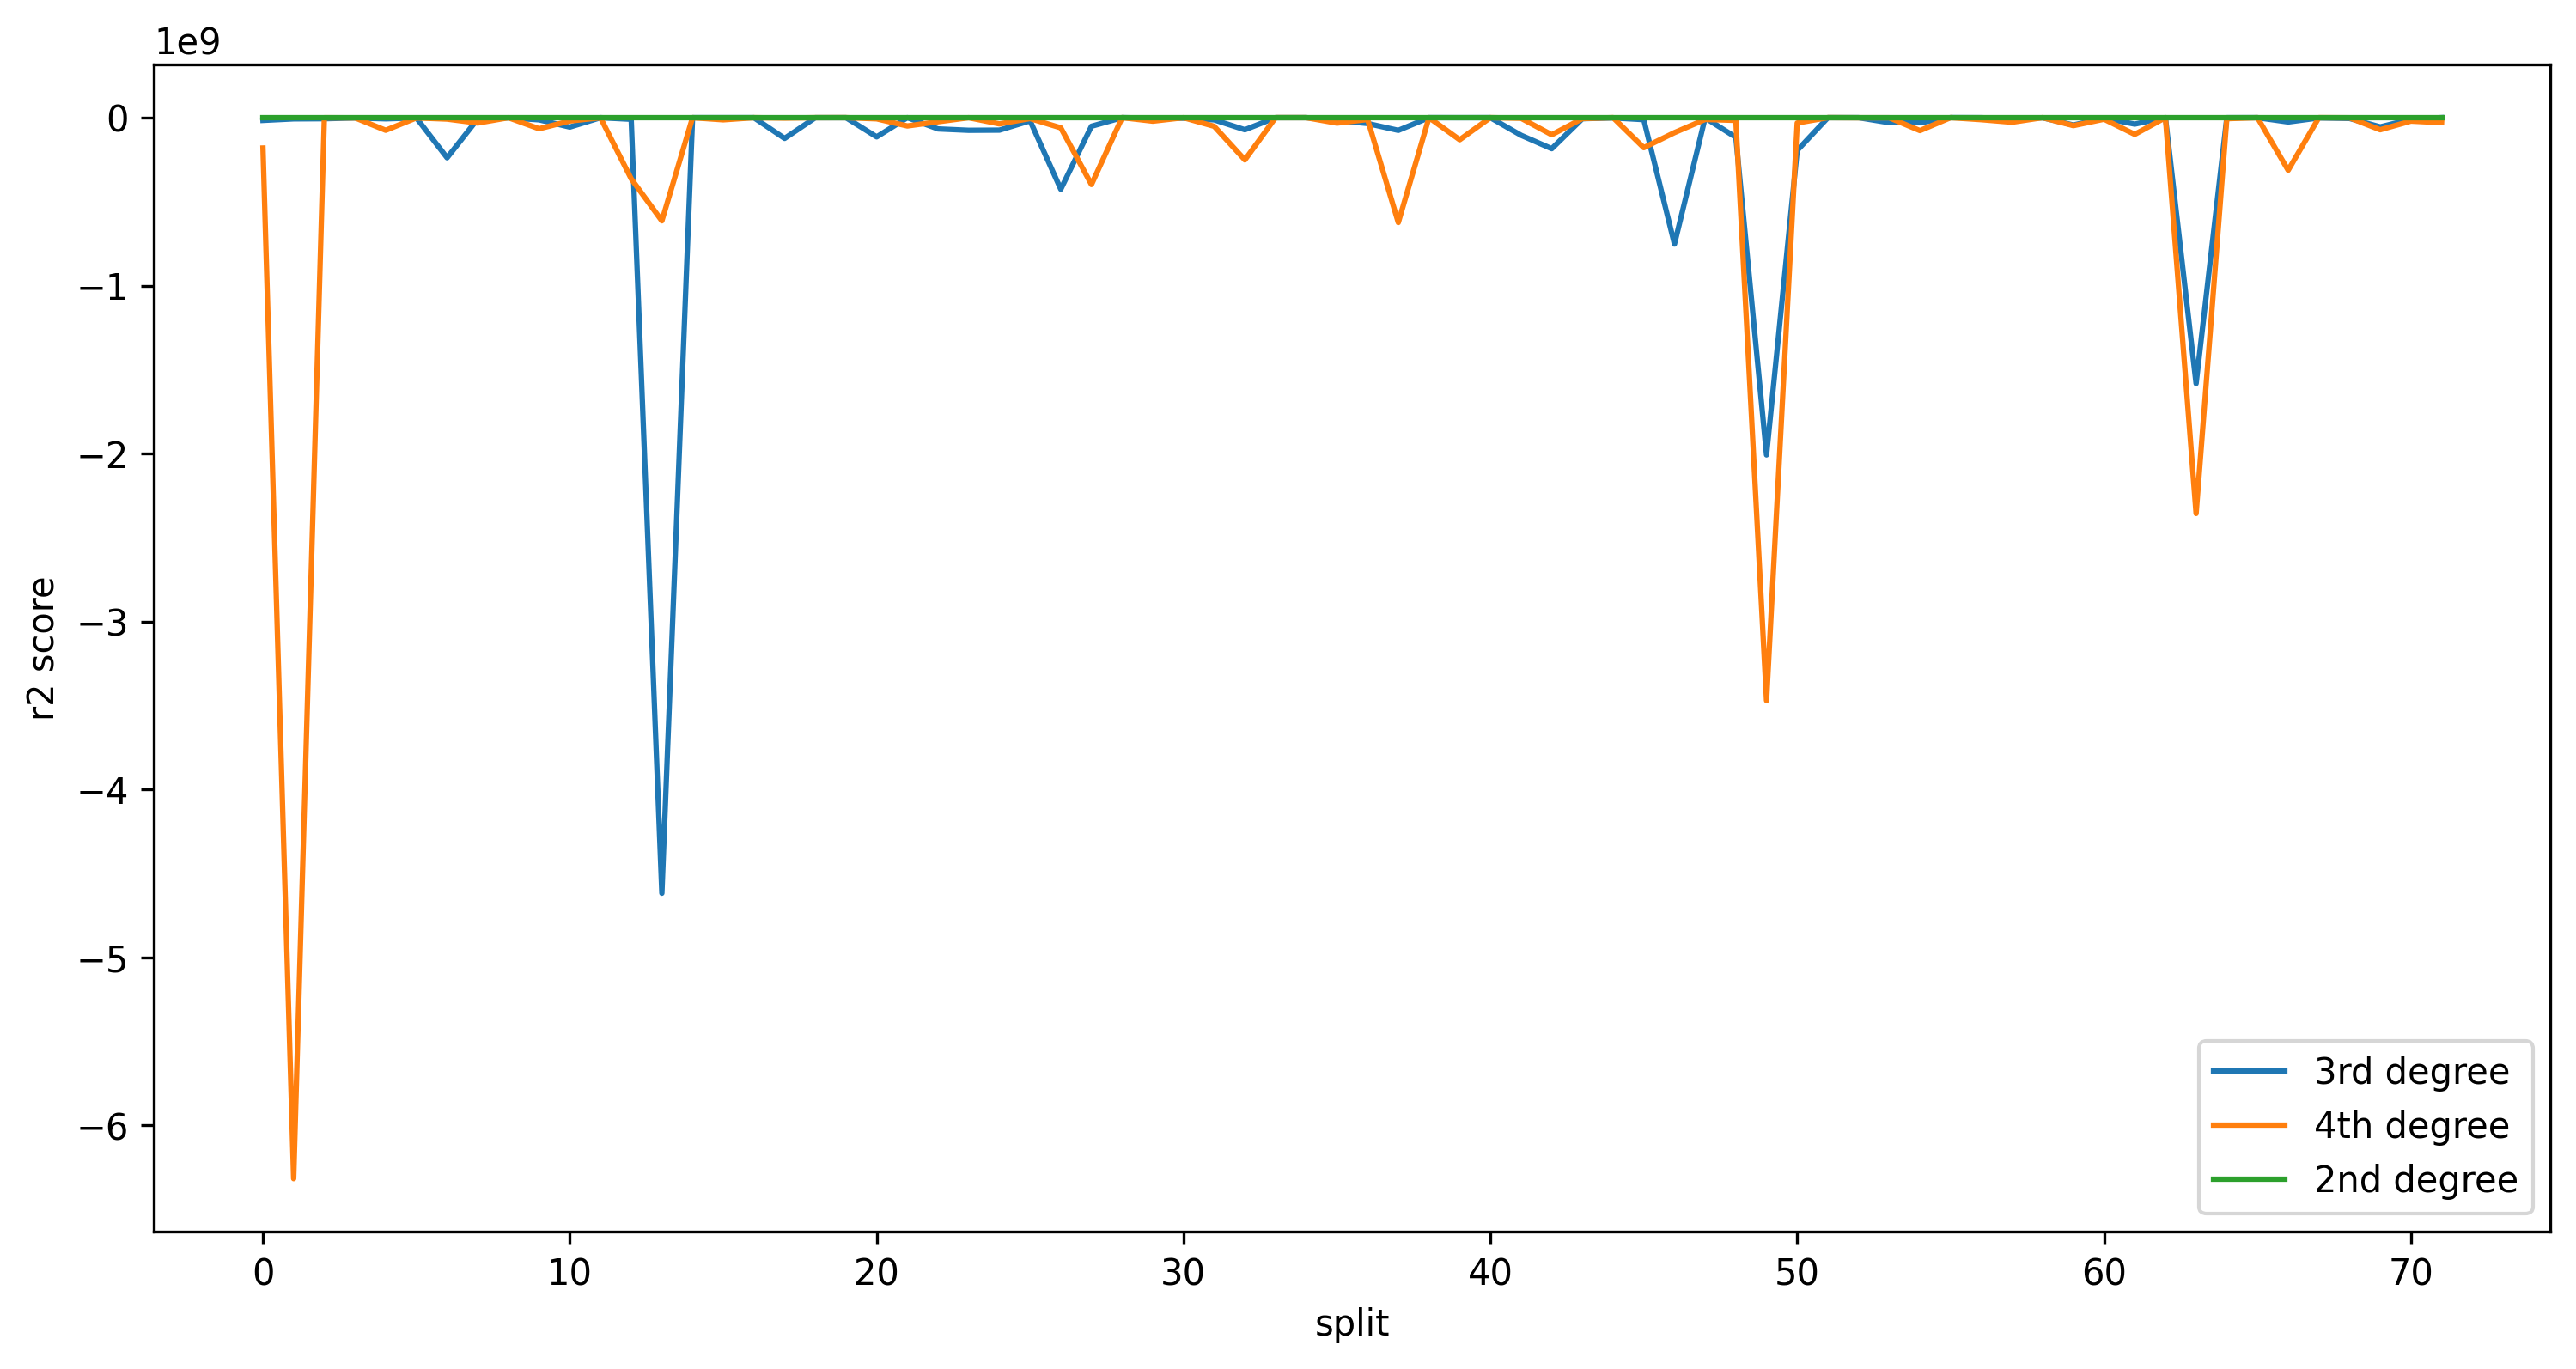

In [35]:
plt.figure(figsize=[12, 6], dpi=300)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_ols.cv_results_).loc[1, 'split0_test_r2': 'split71_test_r2'],
    label='3rd degree'
)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_ols.cv_results_).loc[2, 'split0_test_r2': 'split71_test_r2'],
    label='4th degree'
)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_ols.cv_results_).loc[0, 'split0_test_r2': 'split71_test_r2'],
    label='2nd degree'
)
plt.legend()
plt.xlabel('split')
plt.ylabel('r2 score')
plt.show()

In [42]:
gs_ols.best_score_, gs_ols.best_params_

(0.7806944461598777, {'poly_func__degree': 2})

In [36]:
ridge_estimator = Pipeline(steps=[('poly_func', PolynomialFeatures()),
                                  ('model', Ridge(alpha=0.5, max_iter=5000))])
ridge_estimator.get_params()

{'memory': None,
 'steps': [('poly_func', PolynomialFeatures()),
  ('model', Ridge(alpha=0.5, max_iter=5000))],
 'verbose': False,
 'poly_func': PolynomialFeatures(),
 'model': Ridge(alpha=0.5, max_iter=5000),
 'poly_func__degree': 2,
 'poly_func__include_bias': True,
 'poly_func__interaction_only': False,
 'poly_func__order': 'C',
 'model__alpha': 0.5,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__max_iter': 5000,
 'model__normalize': 'deprecated',
 'model__positive': False,
 'model__random_state': None,
 'model__solver': 'auto',
 'model__tol': 0.001}

In [37]:
gs_ridge = GridSearchCV(estimator=ridge_estimator,
                        param_grid={'poly_func__degree': [2, 3, 4]},
                        scoring={'r2': make_scorer(r2_score),
                                 'me': make_scorer(max_error)
                                 },
                        refit='r2',
                        cv=cv,
                        n_jobs=-1
                        )
gs_ridge.fit(train_x, train_y)

GridSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
             estimator=Pipeline(steps=[('poly_func', PolynomialFeatures()),
                                       ('model',
                                        Ridge(alpha=0.5, max_iter=5000))]),
             n_jobs=-1, param_grid={'poly_func__degree': [2, 3, 4]}, refit='r2',
             scoring={'me': make_scorer(max_error),
                      'r2': make_scorer(r2_score)})

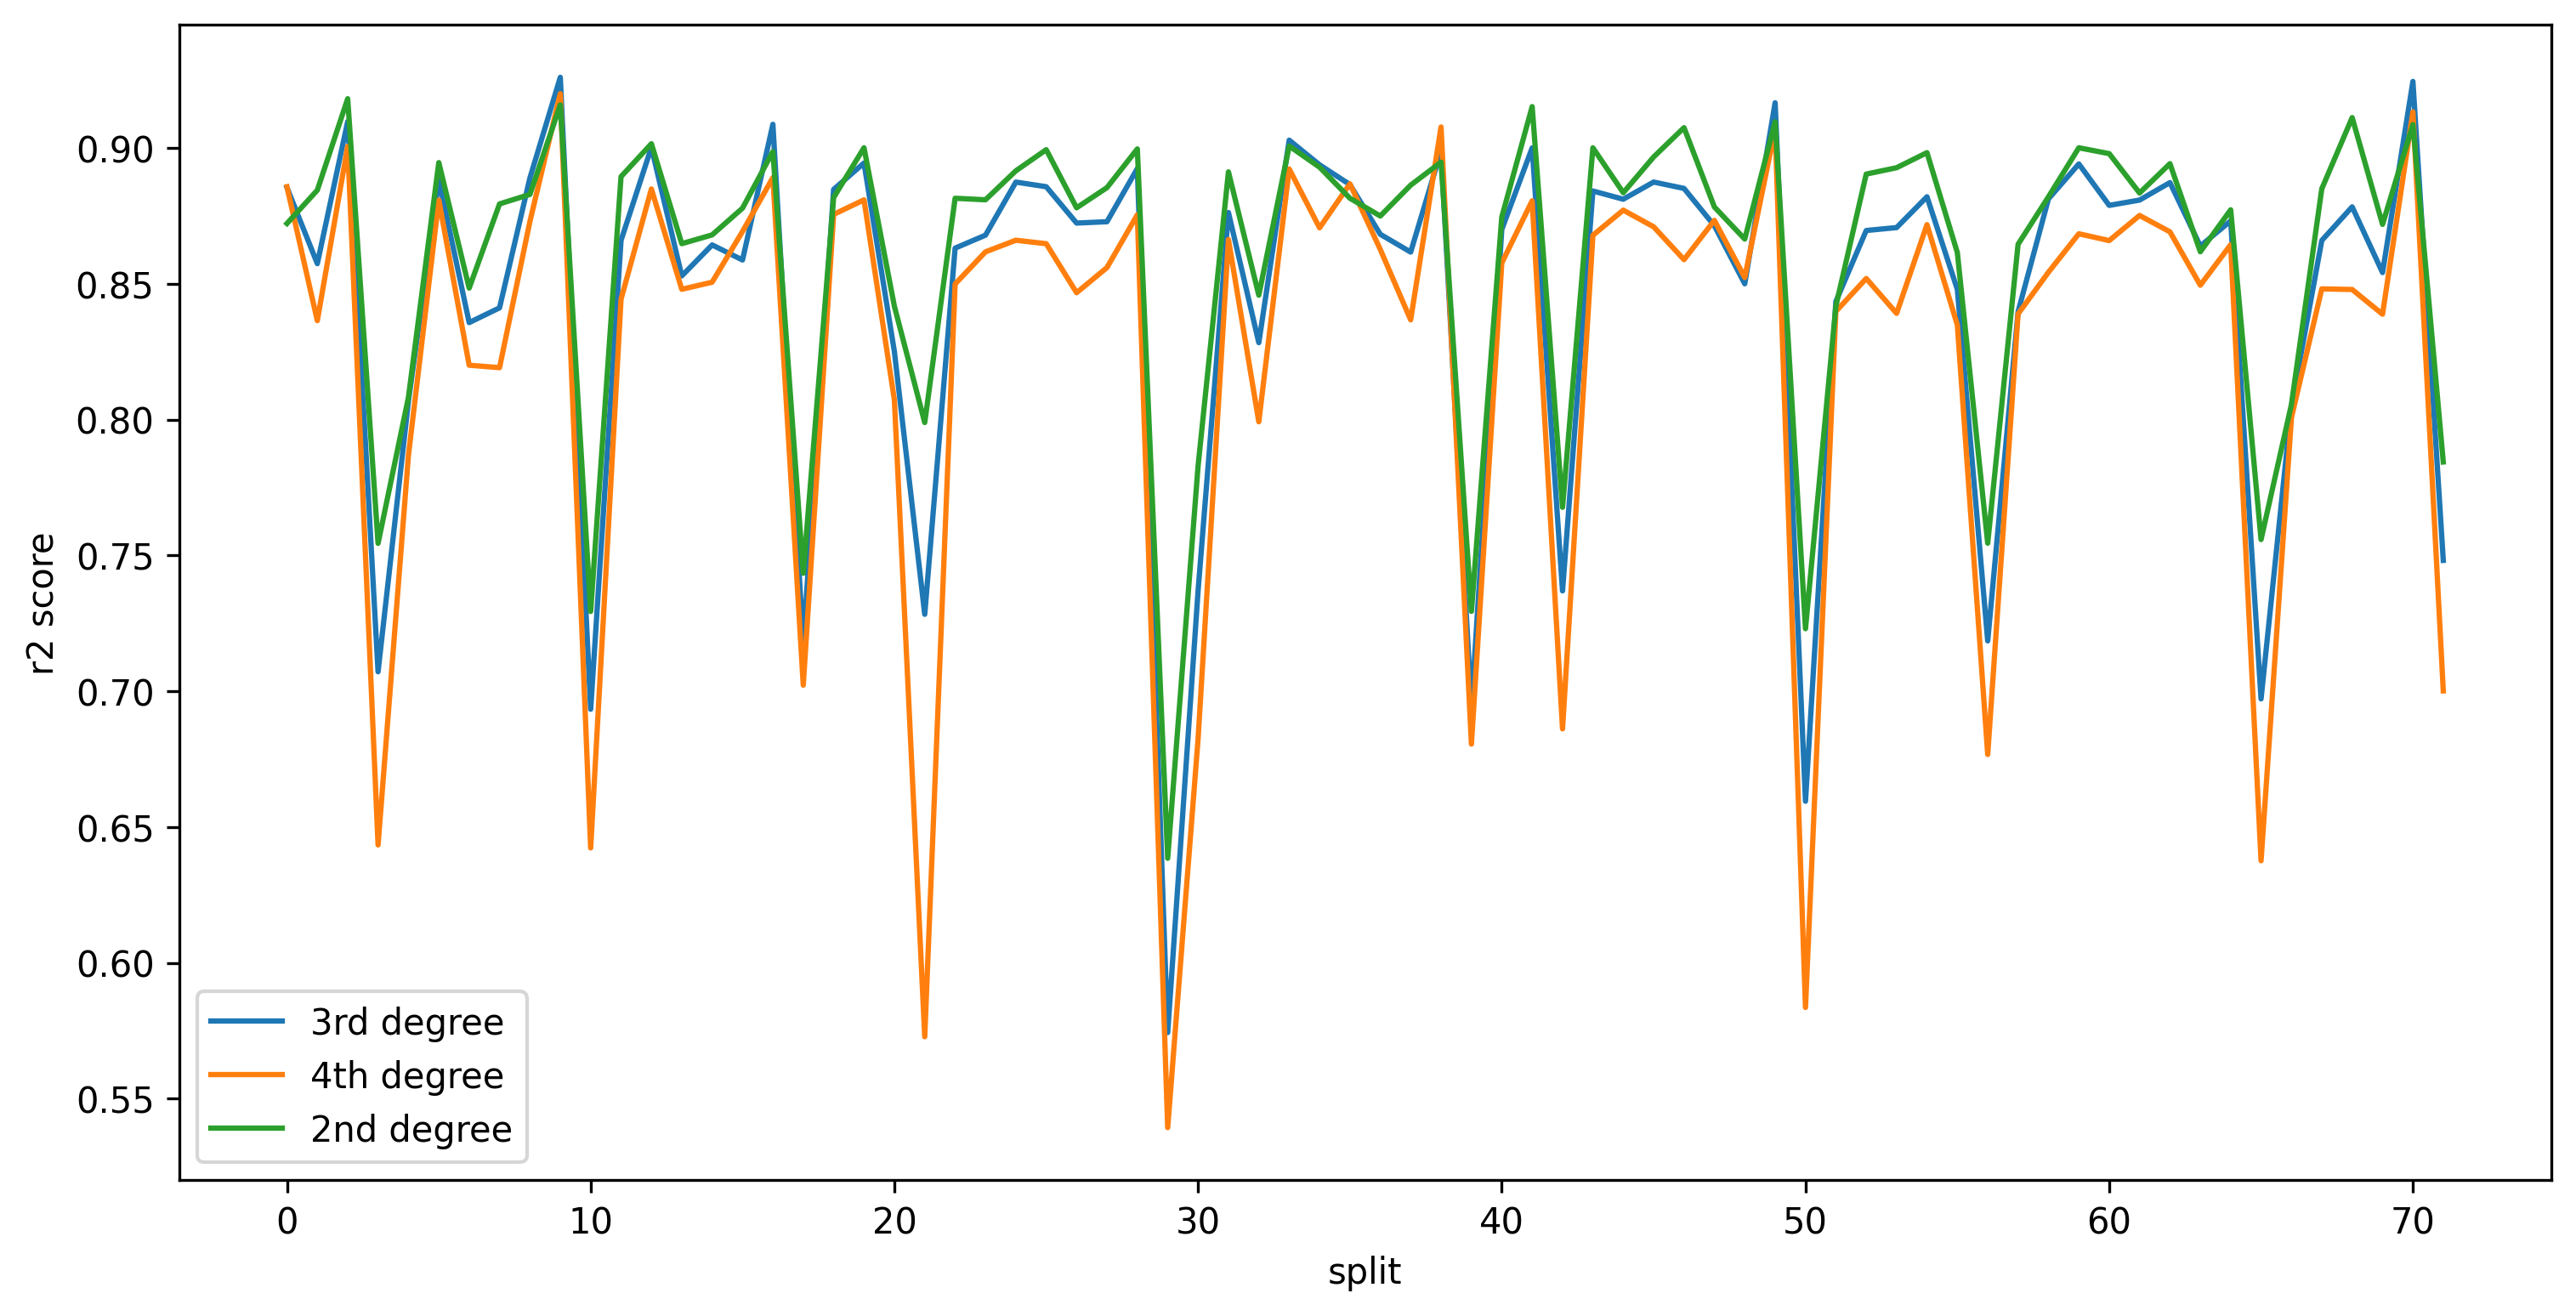

In [41]:
plt.figure(figsize=[12, 6], dpi=300)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_ridge.cv_results_).loc[1, 'split0_test_r2': 'split71_test_r2'],
    label='3rd degree'
)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_ridge.cv_results_).loc[2, 'split0_test_r2': 'split71_test_r2'],
    label='4th degree'
)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_ridge.cv_results_).loc[0, 'split0_test_r2': 'split71_test_r2'],
    label='2nd degree'
)
plt.legend()
plt.xlabel('split')
plt.ylabel('r2 score')
plt.show()

In [44]:
gs_ridge.best_score_, gs_ridge.best_params_

(0.8602211153677806, {'poly_func__degree': 2})

In [46]:
lasso_estimator = Pipeline(steps=[('poly_func', PolynomialFeatures()),
                                  ('model', Lasso(alpha=0.5, max_iter=5000))])
lasso_estimator.get_params()

{'memory': None,
 'steps': [('poly_func', PolynomialFeatures()),
  ('model', Lasso(alpha=0.5, max_iter=5000))],
 'verbose': False,
 'poly_func': PolynomialFeatures(),
 'model': Lasso(alpha=0.5, max_iter=5000),
 'poly_func__degree': 2,
 'poly_func__include_bias': True,
 'poly_func__interaction_only': False,
 'poly_func__order': 'C',
 'model__alpha': 0.5,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__max_iter': 5000,
 'model__normalize': 'deprecated',
 'model__positive': False,
 'model__precompute': False,
 'model__random_state': None,
 'model__selection': 'cyclic',
 'model__tol': 0.0001,
 'model__warm_start': False}

In [47]:
gs_lasso = GridSearchCV(estimator=lasso_estimator,
                        param_grid={'poly_func__degree': [2, 3, 4]},
                        scoring={'r2': make_scorer(r2_score),
                                 'me': make_scorer(max_error)
                                 },
                        refit='r2',
                        cv=cv,
                        n_jobs=-1
                        )
gs_lasso.fit(train_x, train_y)

C:\Users\hewar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e+11, tolerance: 7.405e+08
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=RepeatedKFold(n_repeats=12, n_splits=6, random_state=64),
             estimator=Pipeline(steps=[('poly_func', PolynomialFeatures()),
                                       ('model',
                                        Lasso(alpha=0.5, max_iter=5000))]),
             n_jobs=-1, param_grid={'poly_func__degree': [2, 3, 4]}, refit='r2',
             scoring={'me': make_scorer(max_error),
                      'r2': make_scorer(r2_score)})

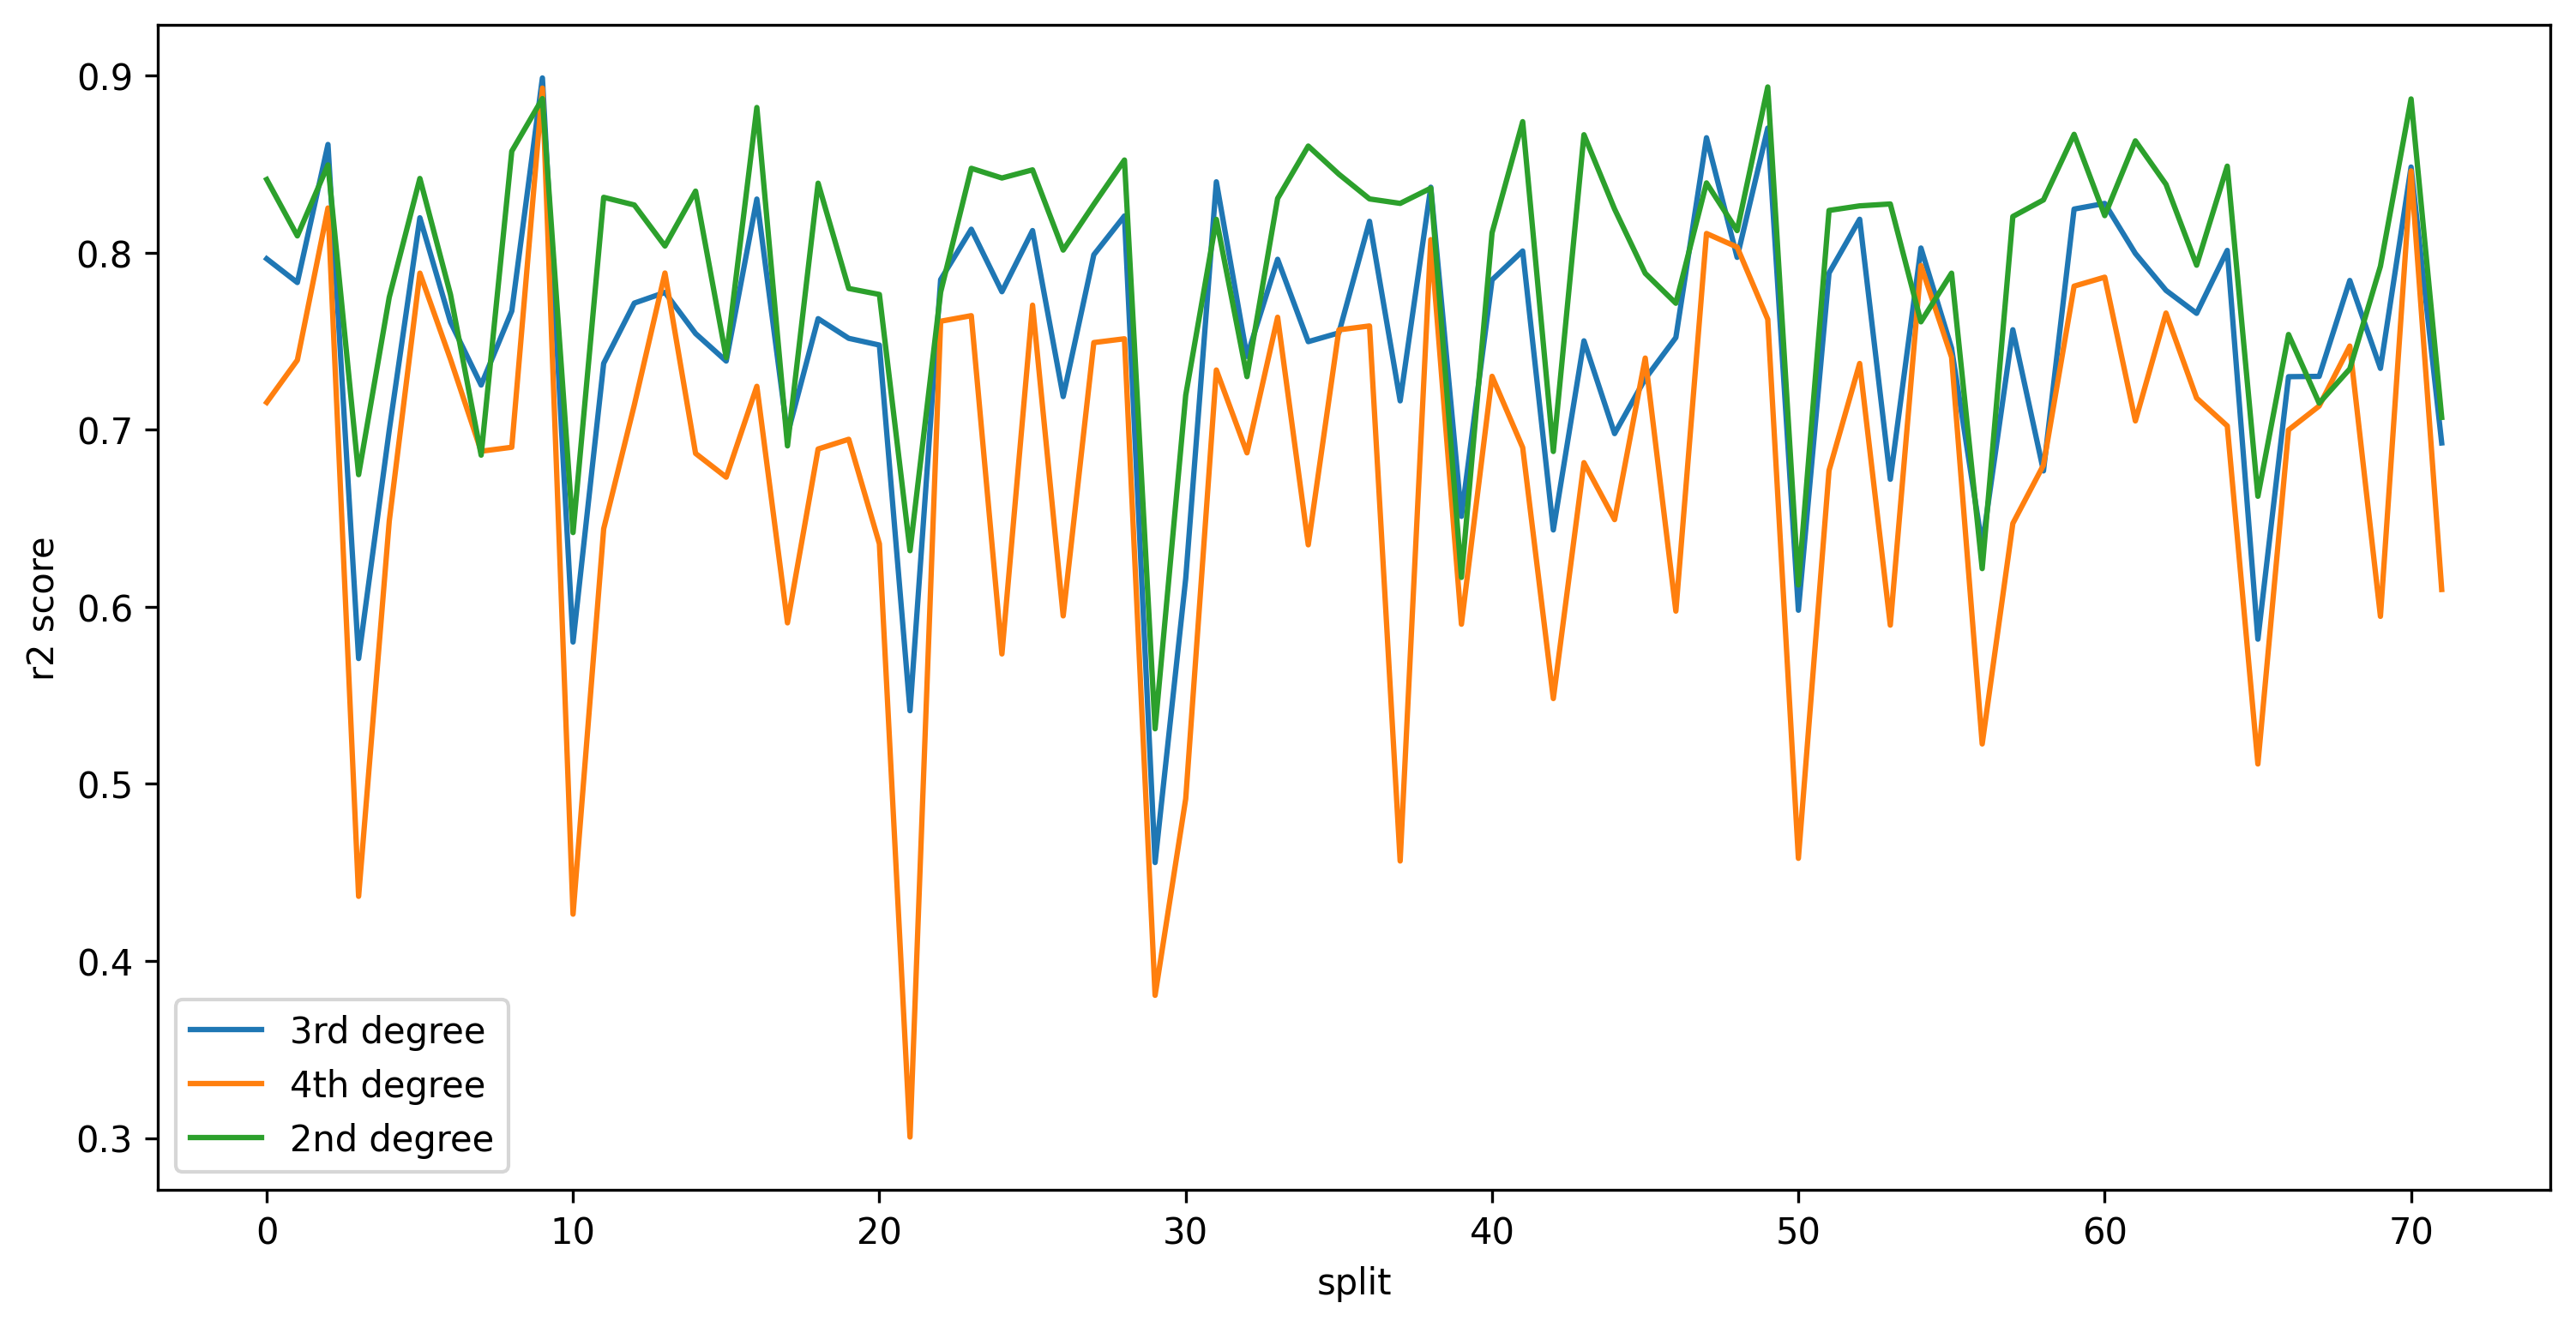

In [48]:
plt.figure(figsize=[12, 6], dpi=300)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_lasso.cv_results_).loc[1, 'split0_test_r2': 'split71_test_r2'],
    label='3rd degree'
)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_lasso.cv_results_).loc[2, 'split0_test_r2': 'split71_test_r2'],
    label='4th degree'
)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_lasso.cv_results_).loc[0, 'split0_test_r2': 'split71_test_r2'],
    label='2nd degree'
)
plt.legend()
plt.xlabel('split')
plt.ylabel('r2 score')
plt.show()

In [49]:
gs_lasso.best_score_, gs_lasso.best_params_

(0.7900594317174146, {'poly_func__degree': 2})

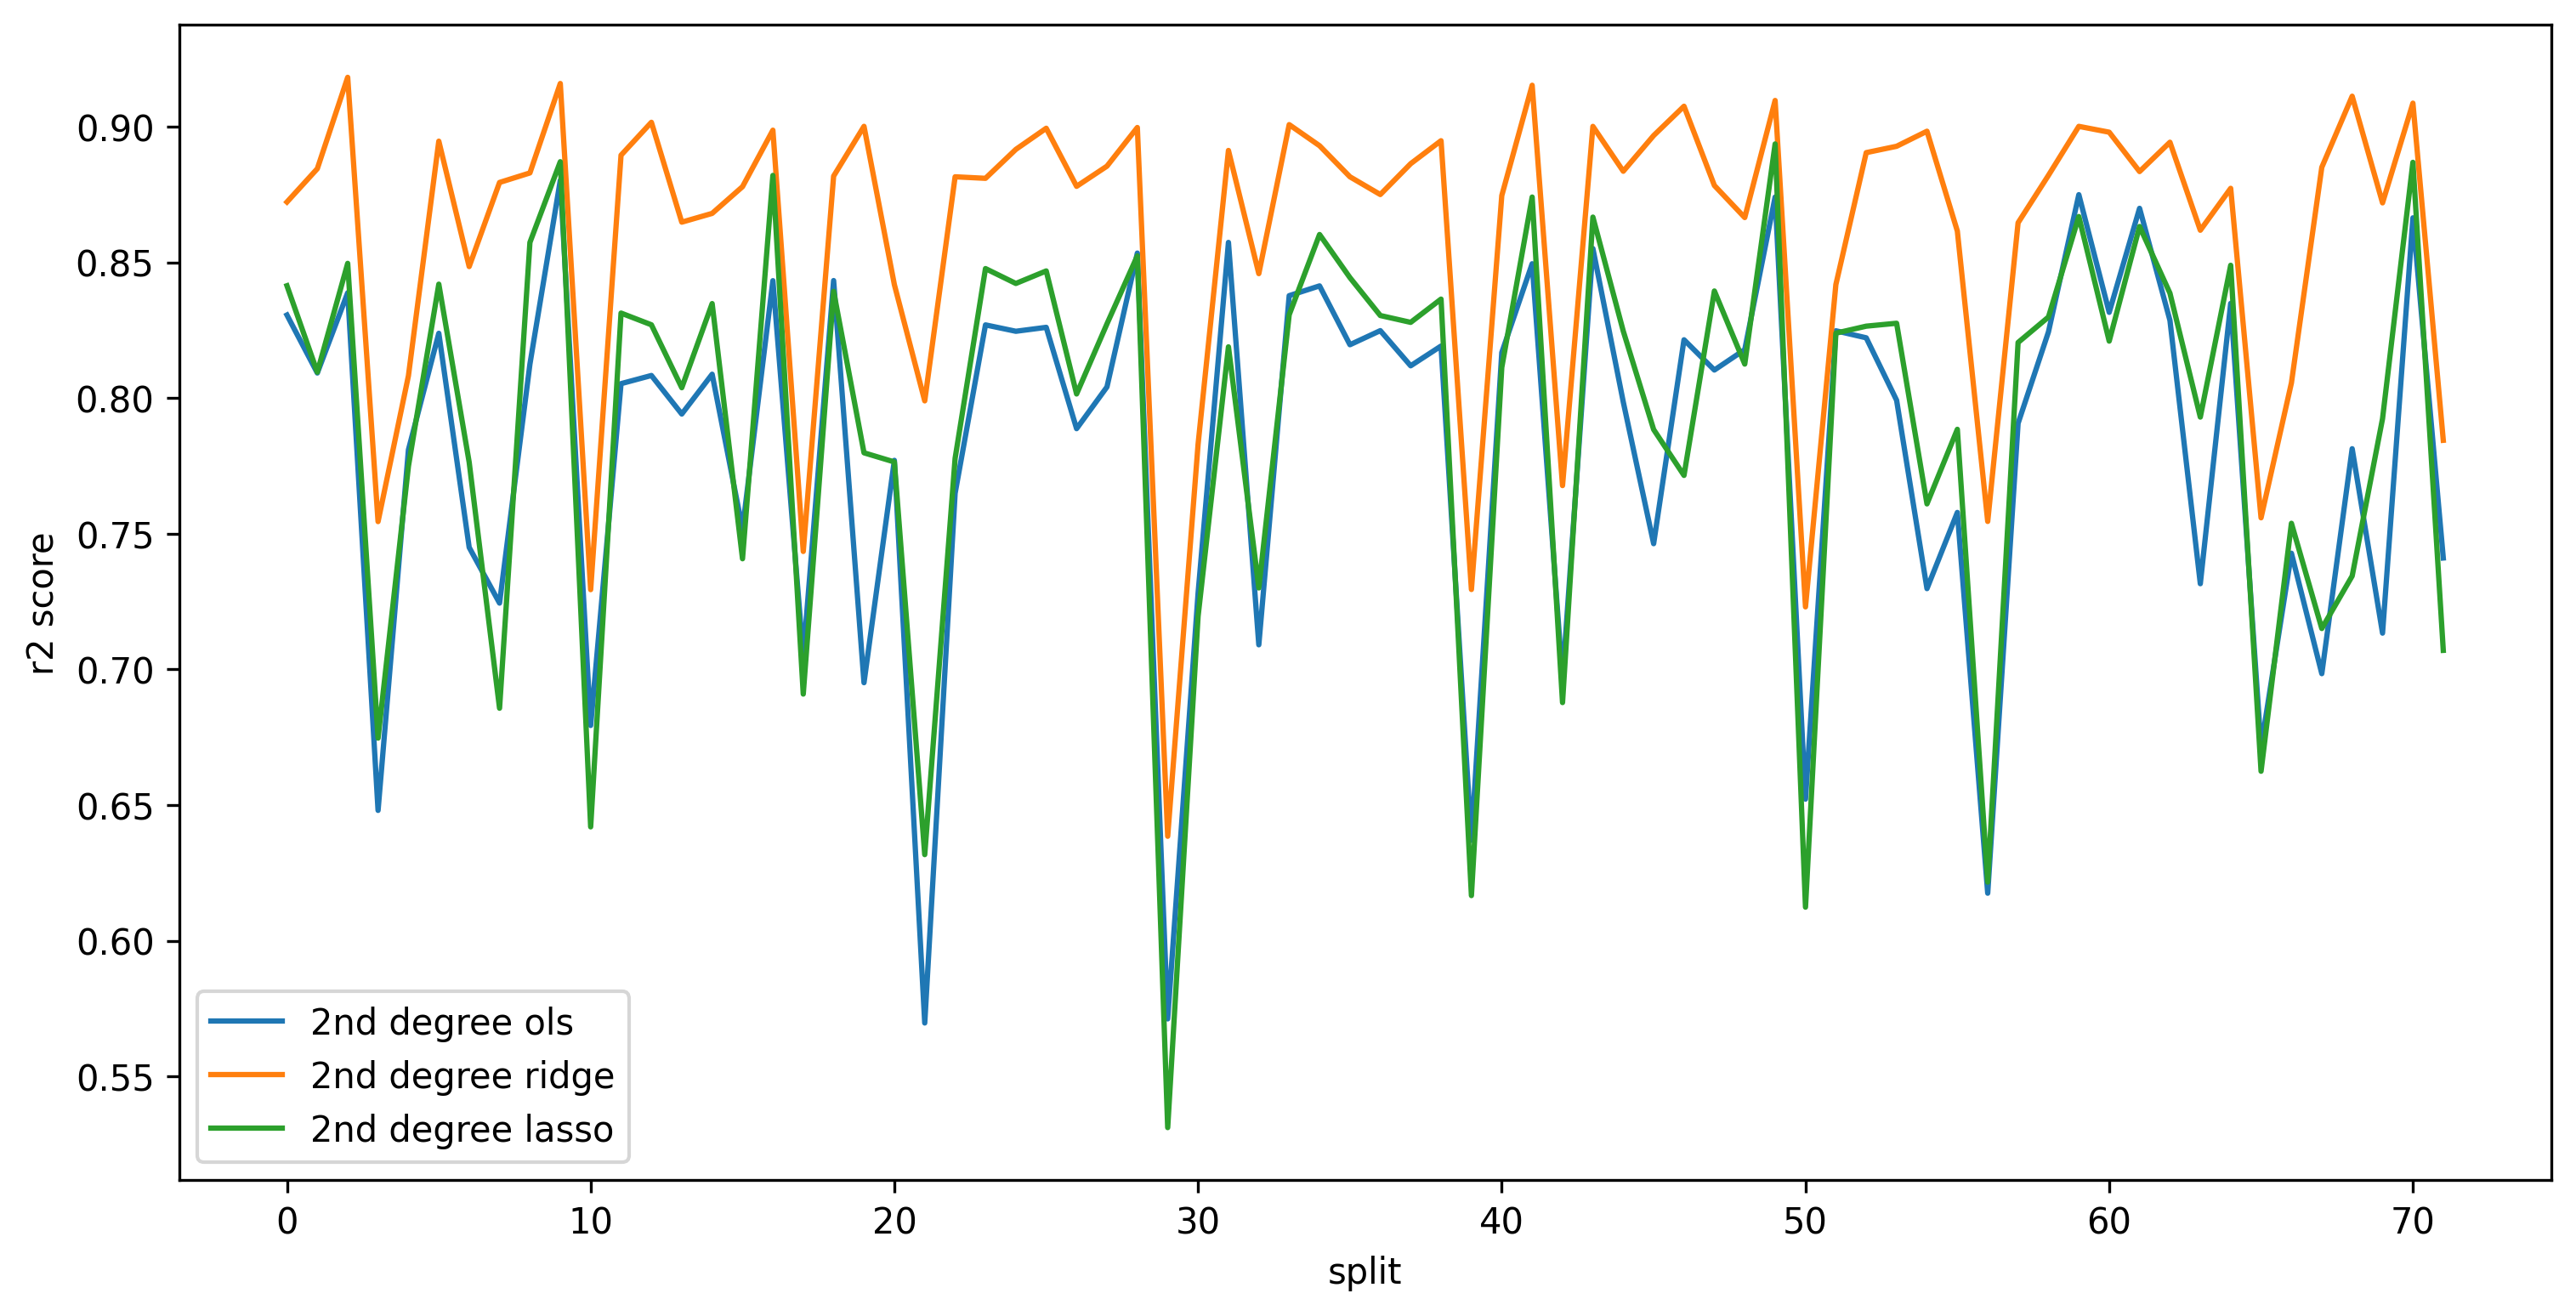

In [51]:
plt.figure(figsize=[12, 6], dpi=300)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_ols.cv_results_).loc[0, 'split0_test_r2': 'split71_test_r2'],
    label='2nd degree ols'
)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_ridge.cv_results_).loc[0, 'split0_test_r2': 'split71_test_r2'],
    label='2nd degree ridge'
)
sns.lineplot(
    x=list(range(72)),
    y=pd.DataFrame(gs_lasso.cv_results_).loc[0, 'split0_test_r2': 'split71_test_r2'],
    label='2nd degree lasso'
)
plt.legend()
plt.xlabel('split')
plt.ylabel('r2 score')
plt.show()